In [1]:
suppressMessages(library("rwwa"))

prep_window <- function (rc = c(1, 1), w = 7, h = 7, res = 120, pch = 20, ...) {
    options(repr.plot.width = rc[2] * w, repr.plot.height = rc[1] * 
        h, repr.plot.res = res)
    par(mfrow = rc, pch = pch, ...)
}

# Choose best AMO covariate

In [46]:
pi <- load_ts("ts/hurricane-melissa_pi_era5.dat", col.names = c("year", "pi"))

amo <- read.csv("data/amo.csv")
amo$year <- substr(amo$time,1,4)
amo$month <- substr(amo$time,6,7)

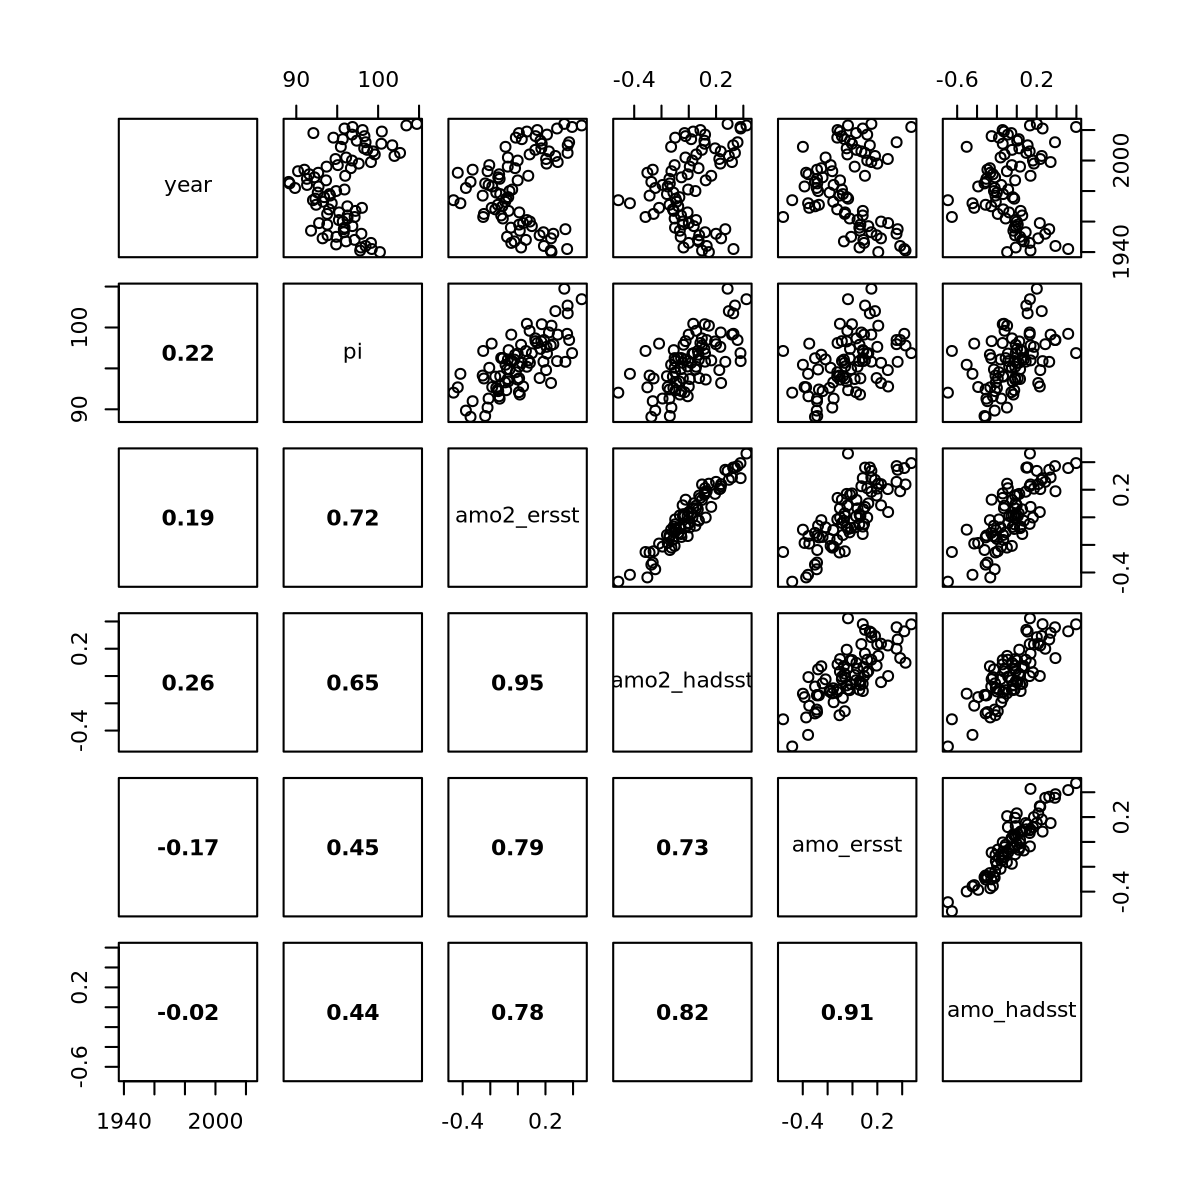

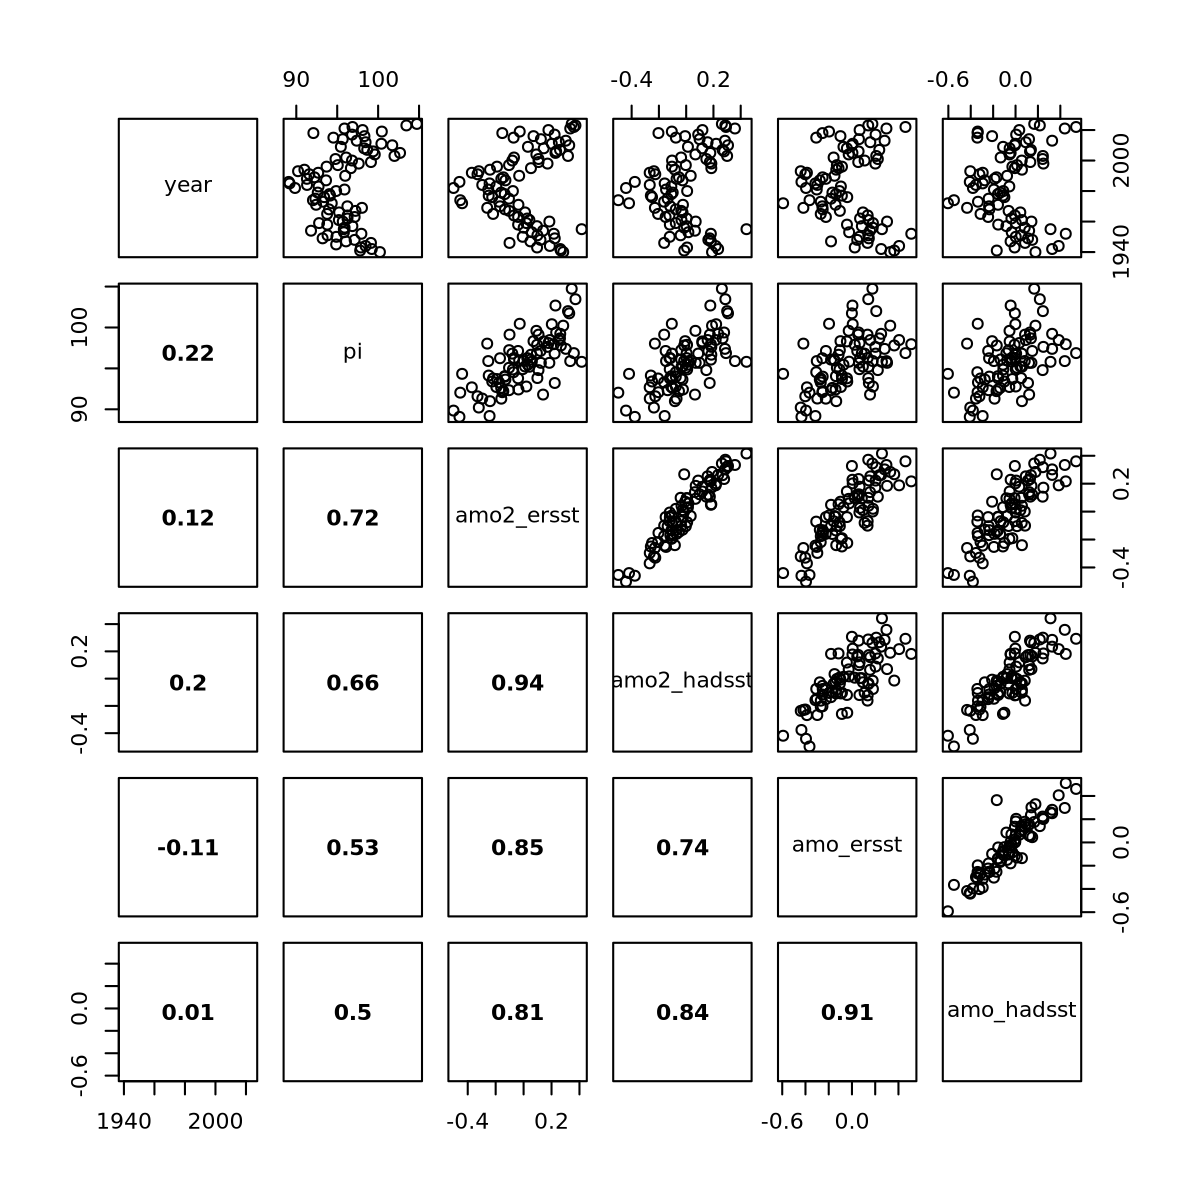

In [58]:
pairs(merge(pi, amo[amo$month == "09",2:6]), lower.panel = panel.cor)
pairs(merge(pi, amo[amo$month == "10",2:6]), lower.panel = panel.cor)
# strongest correlation is with AMO2 (Trenberth method) - either September or October value (use September because available)

## Check my AMO against ClimExp values

In [ ]:
amo_trenberth <- read.csv("data/amo-trenberth_ersst.csv")
amo_trenberth$year <- substr(amo_trenberth$time,1,4)

amo_match <- merge(amo_trenberth[substr(amo_trenberth$time,6,7) == "09",c("year", "amo")], amo[amo$month == "09",c("year", "amo2_ersst")], all = T)

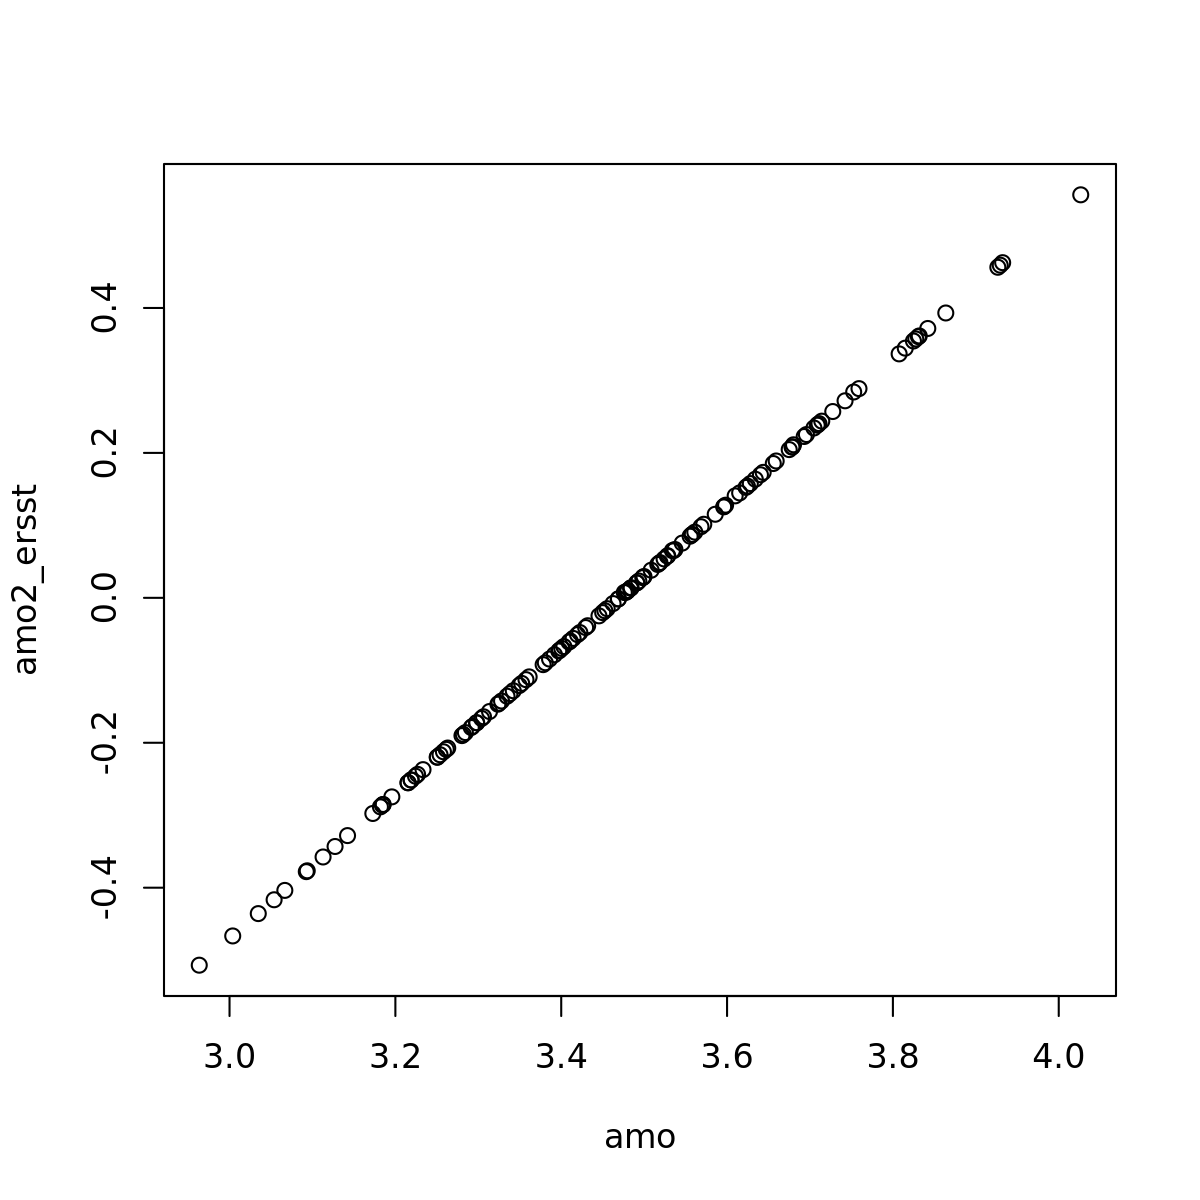

In [80]:
# fixed offset per calendar month so can get September 2025 value
plot(amo_match[,-1])

In [ ]:
amo_offset <- mean(amo_match$amo - amo_match$amo2_ersst, na.rm = T)
amo_trenberth$amo_adj <- amo_trenberth$amo - amo_offset

# Model selection

In [1]:
gmst <- read.table("ts/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]
nino <- load_ts("ts/hurricane-melissa_nino34det-sep_ersst.dat", col.names = c("year", "nino"))
amo <- load_ts("ts/hurricane-melissa_amo-sep_ersst.dat", col.names = c("year", "amo"))
amo_sm <- load_ts("ts//hurricane-melissa_amo-sm10_ersst.dat", col.names = c("year", "amo_sm10"))

df <- merge(merge(merge(merge(gmst, nino), amo), amo_sm), pi)

cov_2025 <- df[df$year == 2025,c("gmst", "nino", "amo", "amo_sm10"),drop = F]
cov_cf <- data.frame(rbind("pi" = c("gmst" = cov_2025$gmst-1.3, "nino" = cov_2025$nino, "amo" = cov_2025$amo, "amo_sm10" = cov_2025$amo_sm10),
                           "ninoneut" = c("gmst" = cov_2025$gmst, "nino" = 0, "amo" = cov_2025$amo, "amo_sm10" = cov_2025$amo_sm10),
                           "amoneut" = c("gmst" = cov_2025$gmst, "nino" = cov_2025$nino, "amo" = 0, "amo_sm10" = cov_2025$amo_sm10),
                           "amo10neut" = c("gmst" = cov_2025$gmst, "nino" = cov_2025$nino, "amo" = cov_2025$amo, "amo_sm10" = 0)))

ERROR: Error in load_ts("ts/hurricane-melissa_nino34det-sep_ersst.dat", col.names = c("year", : could not find function "load_ts"


In [205]:
tna <- read.csv("data/sst_grad_index.csv", col.names = c("year", "tna"))

In [ ]:
z <- merge(df, tna)

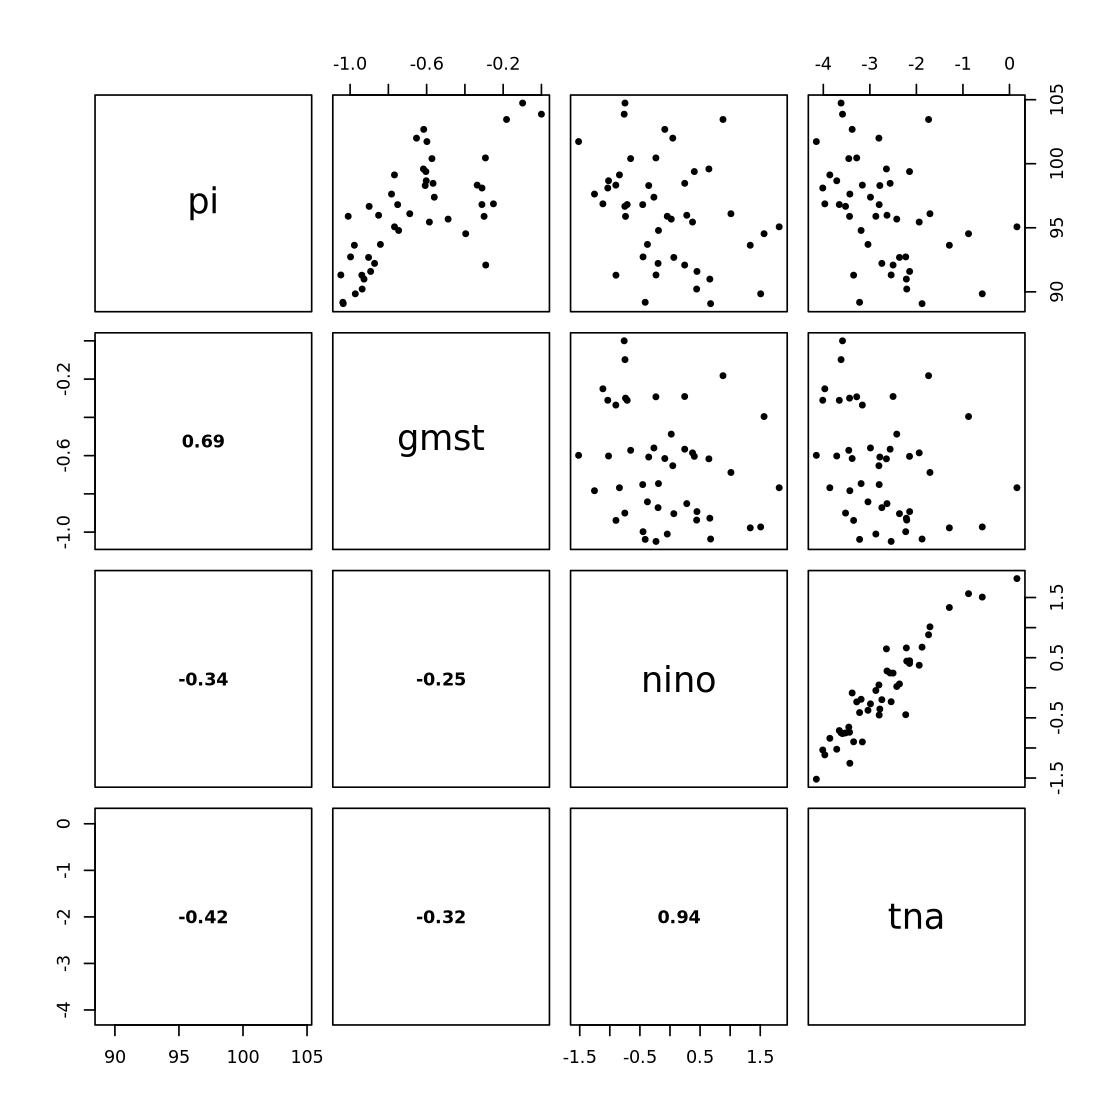

In [212]:
prep_window(, res = 160)
pairs(z[,c("pi", "gmst", "nino", "tna")], lower.panel = panel.cor)

## Covariates

In [228]:
mlist <- list("GMST" = fit_ns("norm", "shift", data = df, covnm = "gmst", varnm = "pi", lower = F),
              "GMST + Nino" = fit_ns("norm", "shift", data = df, covnm = c("gmst", "nino"), varnm = "pi", lower = F),
              "GMST + AMO-Sep" = fit_ns("norm", "shift", data = df, covnm = c("gmst", "amo"), varnm = "pi", lower = F),
              "GMST + smoothed AMO" = fit_ns("norm", "shift", data = df, covnm = c("gmst", "amo_sm10"), varnm = "pi", lower = F),
              "GMST + smoothed AMO + Nino" = fit_ns("norm", "shift", data = df, covnm = c("gmst", "amo_sm10", "nino"), varnm = "pi", lower = F)
              )

In [272]:
round(setNames(data.frame(t(rbind.fill(sapply(mlist, function(mdl) data.frame(t(mdl_ests(mdl, cov_f = cov_2025, cov_cf = cov_cf))), simplify = F)))),
                             names(mlist))[-c(10:15),], 2)

,GMST,GMST + Nino,GMST + AMO-Sep,GMST + smoothed AMO,GMST + smoothed AMO + Nino
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mu0,99.86,99.60,97.77,8.252000e+01,8.294000e+01
sigma0,2.93,2.86,2.31,2.290000e+00,2.270000e+00
alpha_gmst,4.32,4.12,2.22,2.820000e+00,2.770000e+00
disp,0.03,0.03,0.02,2.000000e-02,2.000000e-02
event_magnitude,103.87,103.87,103.87,1.038700e+02,1.038700e+02
return_period,11.70,9.67,357.95,4.160000e+00,3.890000e+00
PR_pi,169.35,122.21,95.47,2.273000e+01,2.040000e+01
dI_abs_pi,5.61,5.36,2.88,3.670000e+00,3.600000e+00
dI_rel_pi,5.71,5.44,2.85,3.660000e+00,3.590000e+00


In [230]:
round(sapply(mlist, function(mdl) c("aic" = aic(mdl), rsquared(mdl))), 3)
       

,GMST,GMST + Nino,GMST + AMO-Sep,GMST + smoothed AMO,GMST + smoothed AMO + Nino
aic,434.732,432.580,396.097,394.839,395.029
r2,0.214,0.251,0.510,0.517,0.527
r2.adj,0.204,0.233,0.498,0.505,0.510


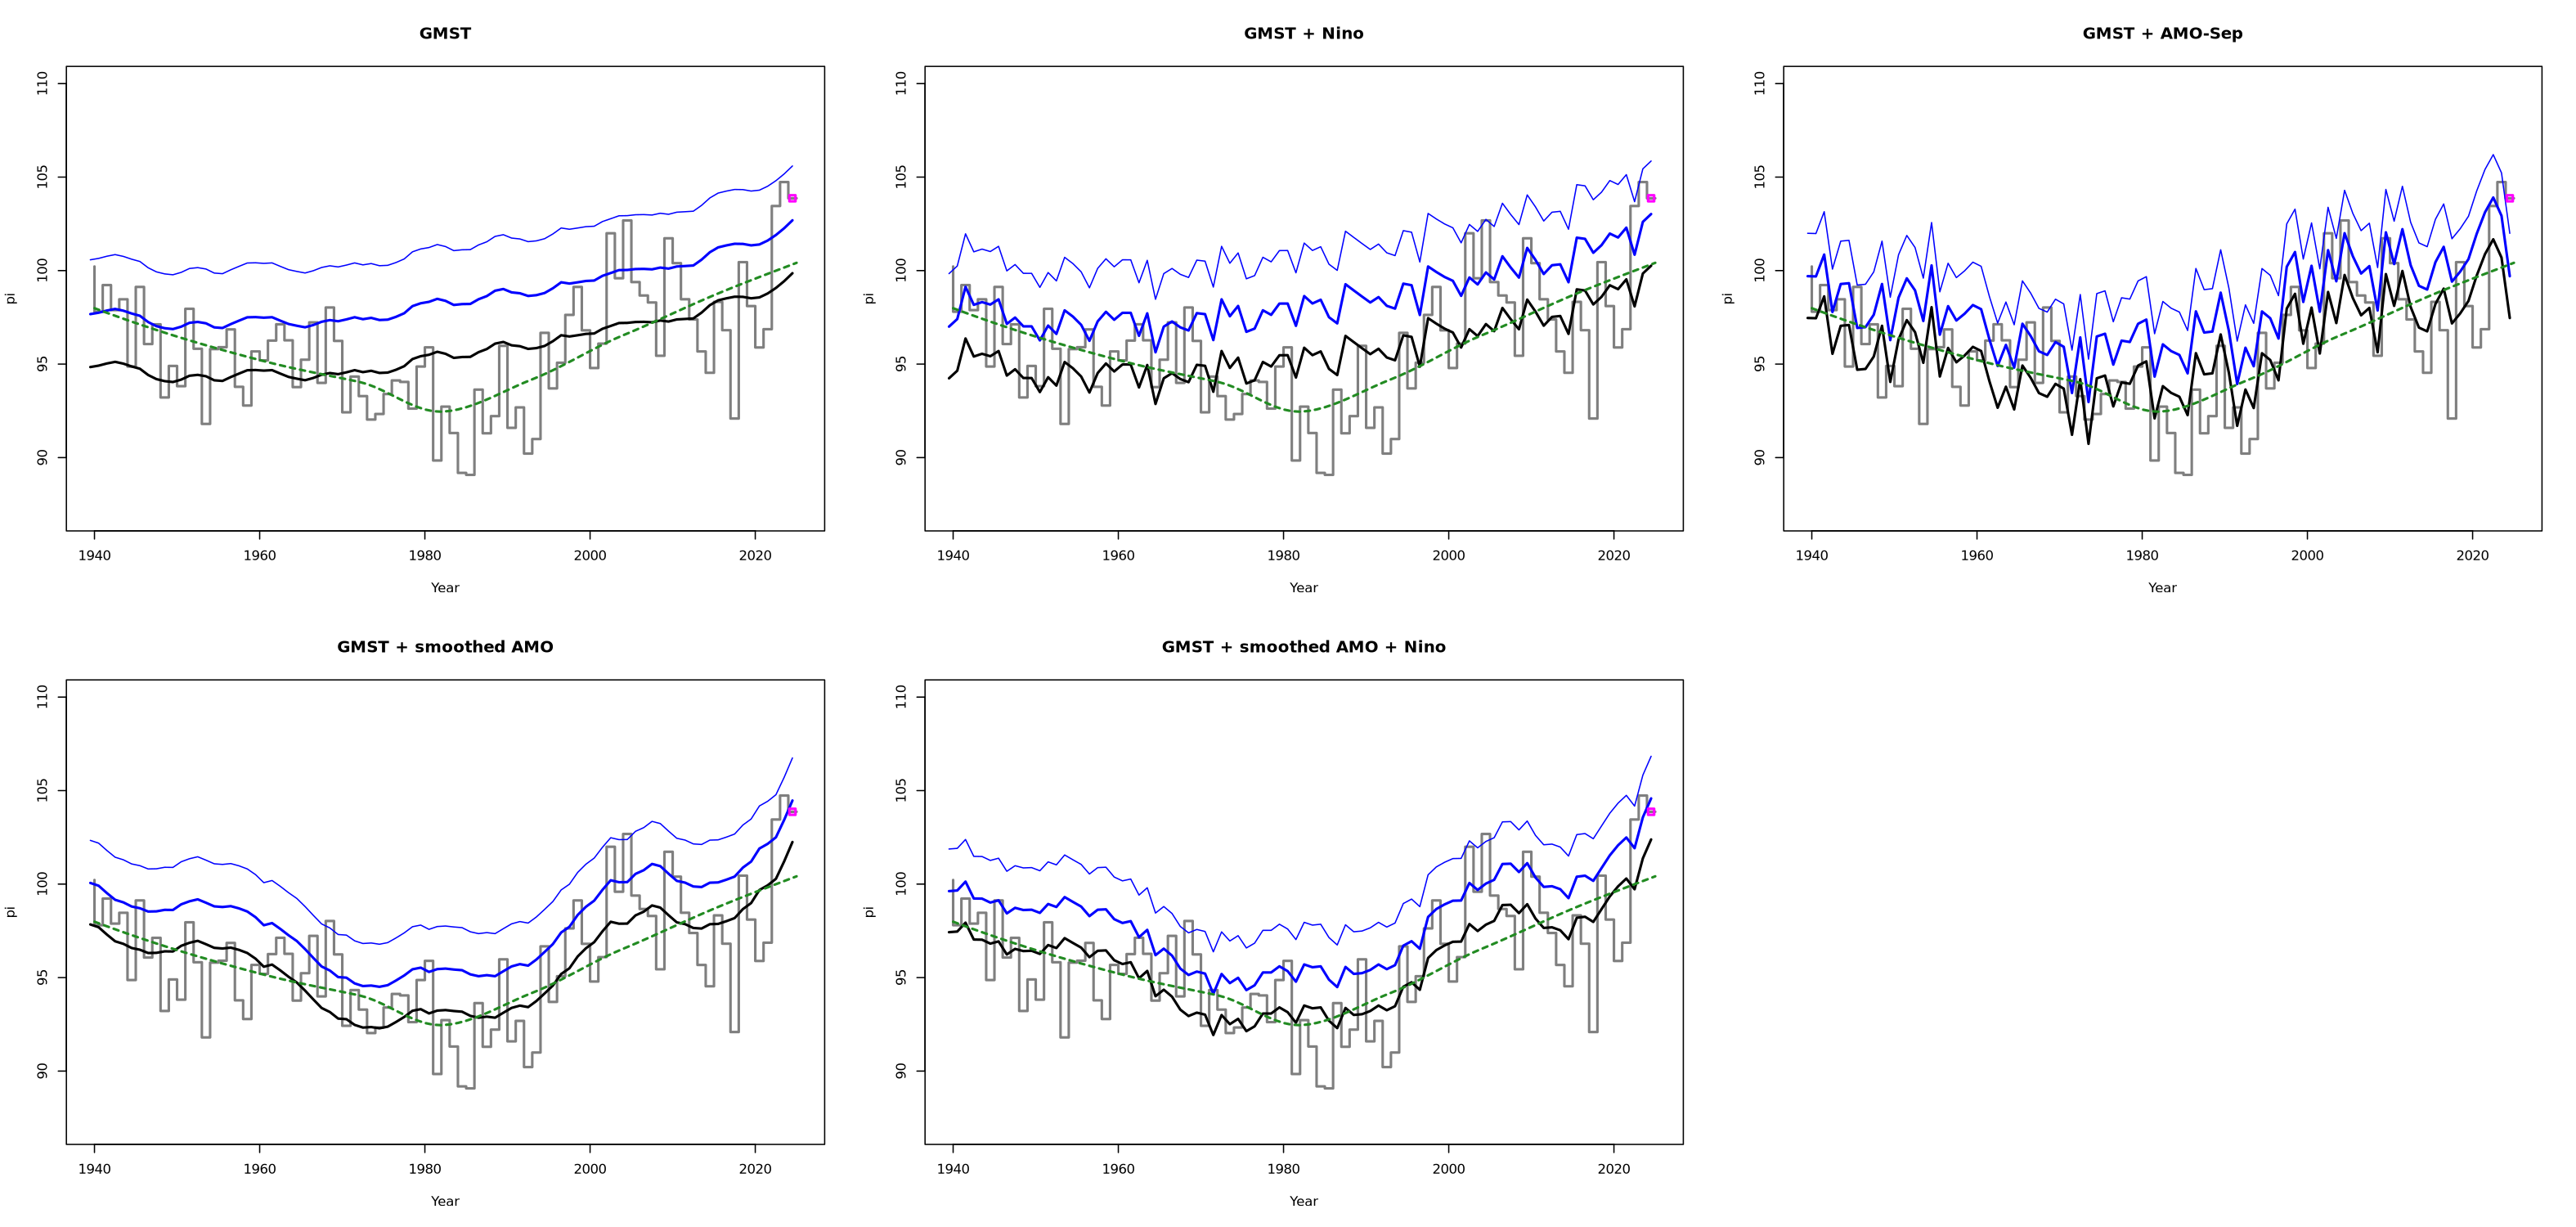

In [235]:
prep_window(c(2,3), w = 7, h = 5, res = 150)
ylim <- c(87,110)

for (i in 1:length(mlist)) plot_trend(mlist[[i]], ylim = ylim, main = names(mlist)[i], legend_pos = NA, lwd = 2)

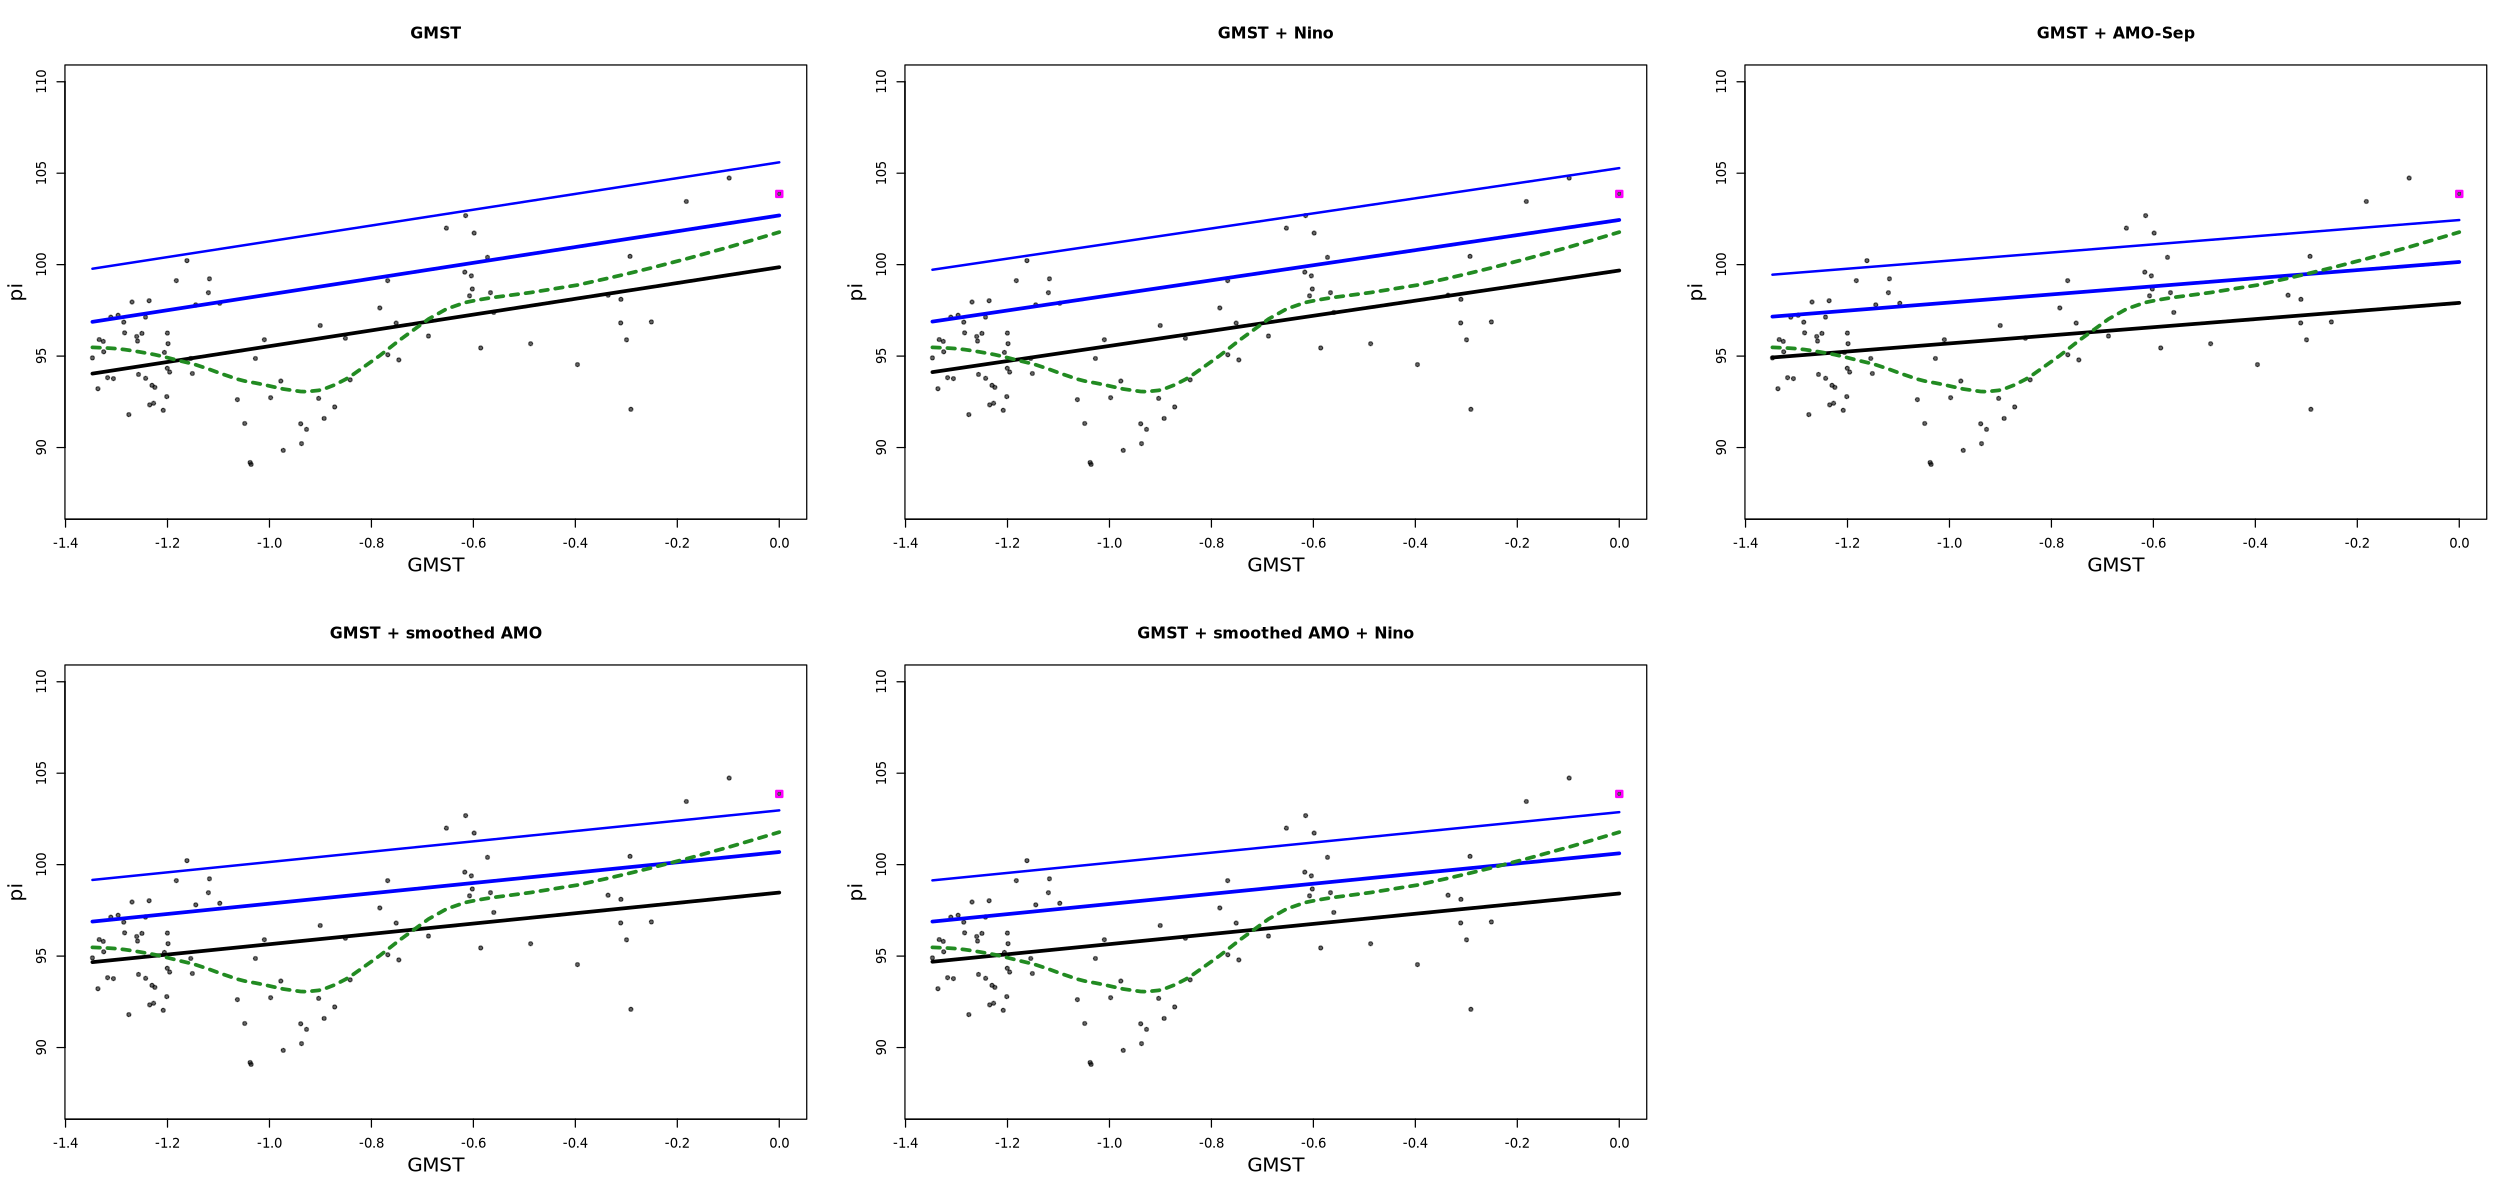

In [238]:
prep_window(c(2,3), w = 7, h = 5, res = 120)
ylim <- c(87,110)
for (i in 1:length(mlist)) plot_covtrend(mlist[[i]], "gmst", ylim = ylim, main = names(mlist)[i], legend_pos = NA)

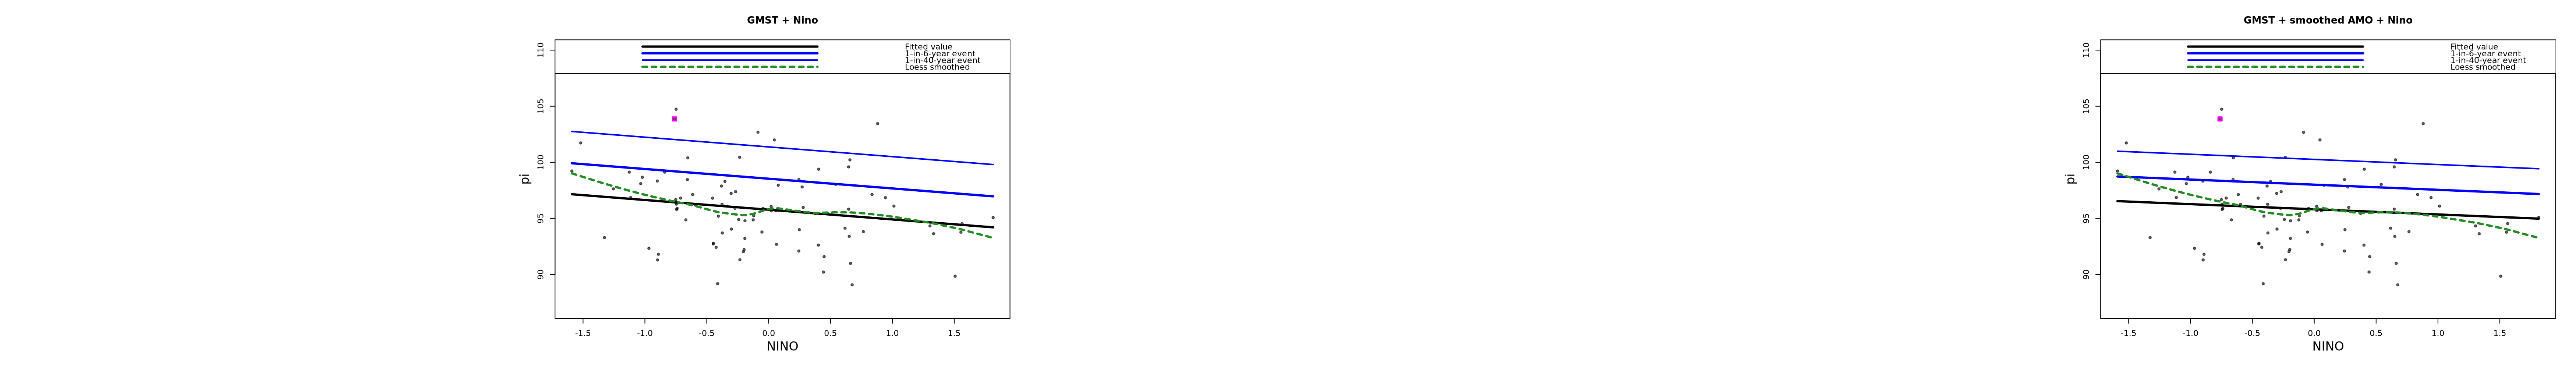

In [177]:
prep_window(c(1,length(mlist)), w = 7, h = 5, res = 200)
ylim <- c(87,110)
for (i in 1:length(mlist)) {
    mname <- names(mlist)[i]
    mdl <- mlist[[mname]]
    if ("nino" %in% mdl$covnm) {
        plot_covtrend(mdl, "nino", ylim = ylim, main = mname)
    } else {plot.new()}
}

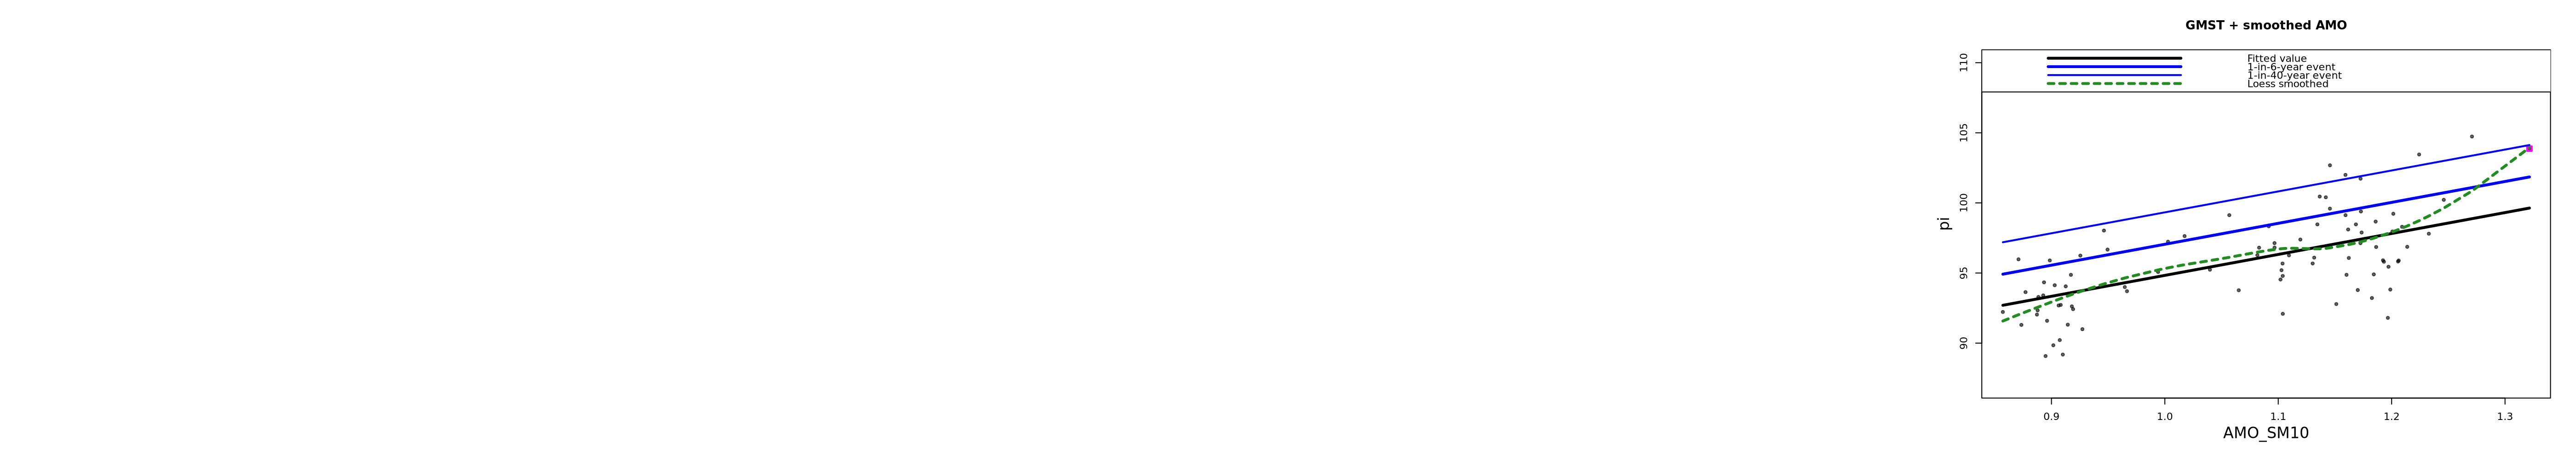

In [170]:
prep_window(c(1,length(mlist)), w = 7, h = 5, res = 200)
ylim <- c(87,110)
for (i in 1:4) {
    mname <- names(mlist)[i]
    mdl <- mlist[[mname]]
    if ("amo_sm10" %in% mdl$covnm) {
        plot_covtrend(mdl, "amo_sm10", ylim = ylim, main = mname)
    } else {plot.new()}
}

In [ ]:
res <- boot_ci(mlist[[4]], cov_f = cov_2025, cov_cf = cov_cf)

In [183]:
round(res[-c(11:17),], 3)

,est,2.5%,97.5%
mu0,82.521,78.100,86.829
sigma0,2.294,1.945,2.535
alpha_gmst,2.824,1.192,4.371
alpha_amo_sm10,14.930,11.346,18.513
disp,0.022,0.019,0.025
event_magnitude,103.867,103.867,103.867
return_period,4.157,2.049,17.636
PR_pi,22.728,4.071,192.919
dI_abs_pi,3.671,1.550,5.682
dI_rel_pi,3.664,1.515,5.787


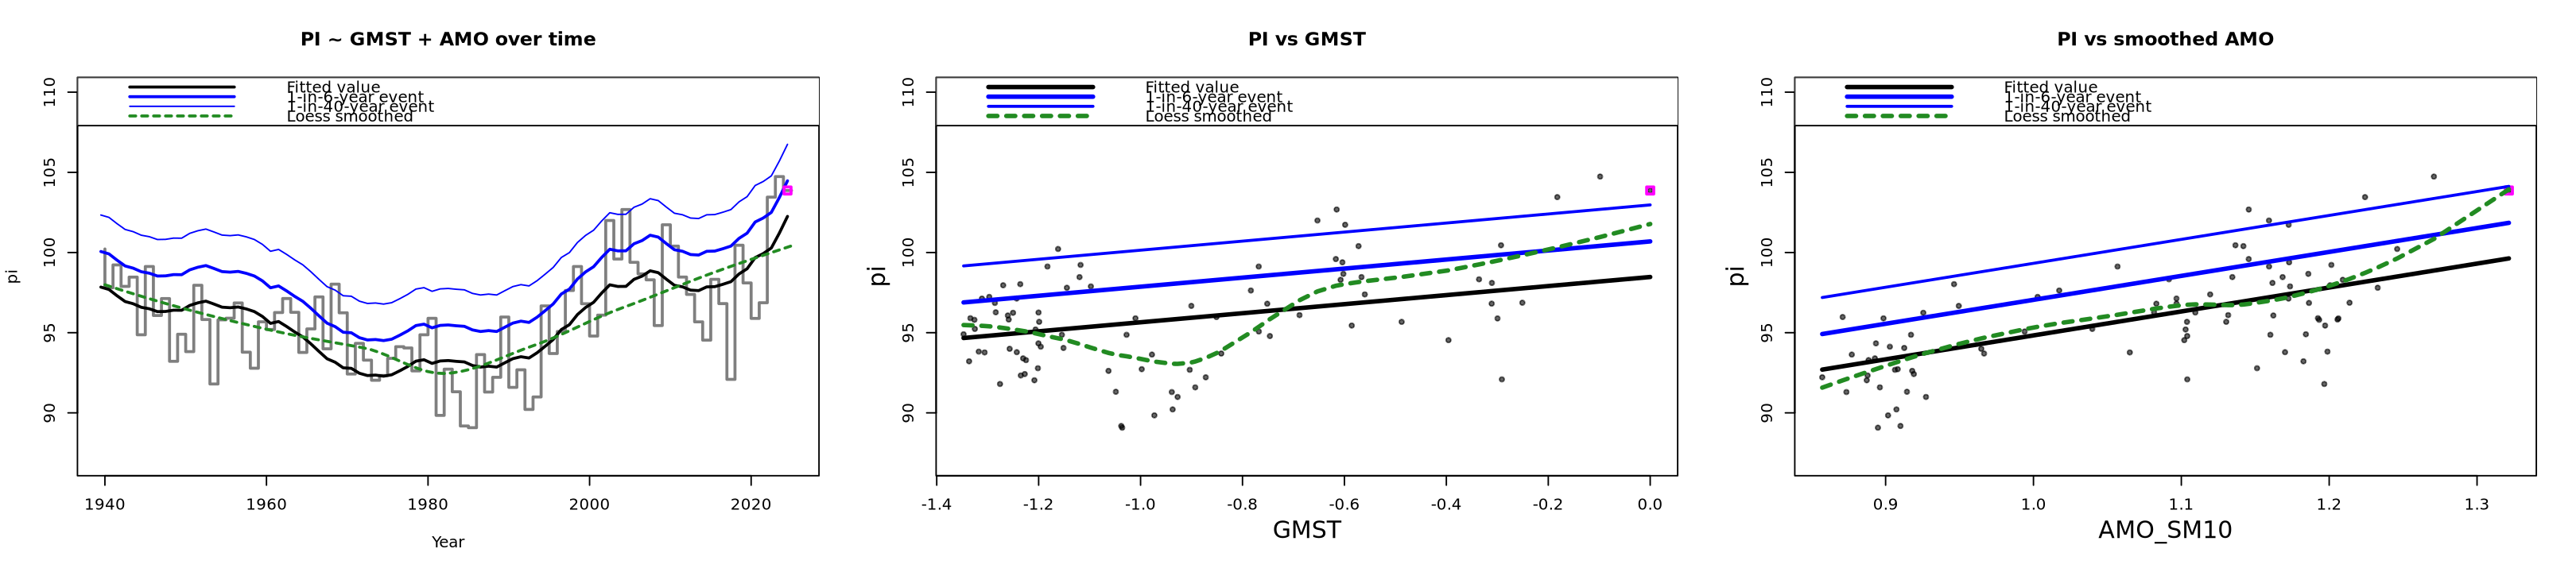

In [191]:
mdl <- mlist[[4]]

prep_window(c(1,3), h = 4, w = 6, res = 180)

plot_trend(mdl, ylim = ylim, main = "PI ~ GMST + AMO over time")
plot_covtrend(mdl, "gmst", ylim = ylim, main = "PI vs GMST")
plot_covtrend(mdl, "amo_sm10", ylim = ylim, main = "PI vs smoothed AMO")

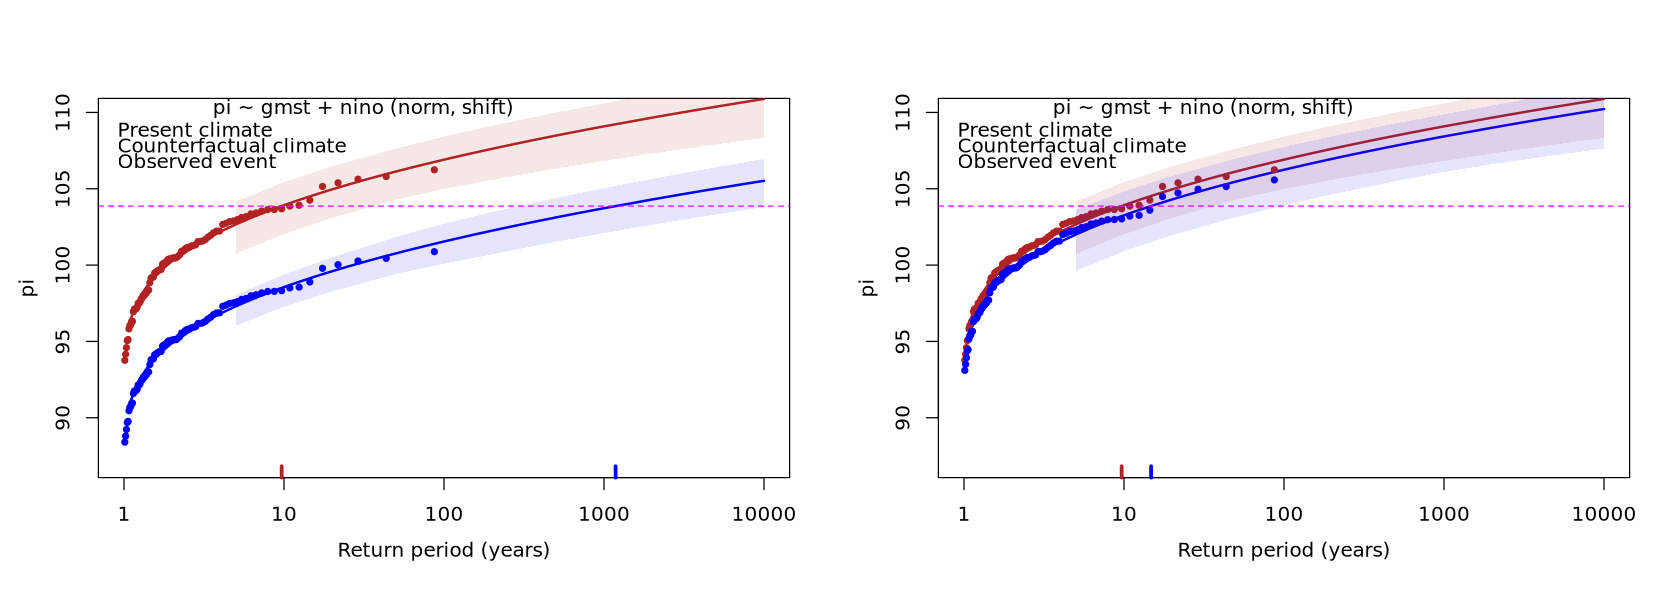

In [ ]:
prep_window(c(1,2), w = 7, h = 5)
ylim <- c(87,110)
# plot_covtrend(mdl_gmst, "gmst", ylim = ylim)
plot_returnlevels(mdl_gmstnino, cov_f = cov_2025, cov_cf = cov_cf["pi",,drop = F], nsamp = 50, ylim = ylim)
plot_returnlevels(mdl_gmstnino, cov_f = cov_2025, cov_cf = cov_cf["neut",,drop = F], nsamp = 50, ylim = ylim)

## Truncation of data

### Effect of shorter time series on GMST-only trend

In [240]:
mlist_gmst <- sapply(c("1940","1950","1970","1980"), function(y) fit_ns("norm", "shift", data = df[df$year >= y,], covnm = c("gmst"), varnm = "pi", lower = F), simplify = F)

In [244]:
sapply(mlist_gmst, function(mdl) c("aic/nobs" = aic(mdl) / length(mdl$x), rsquared(mdl)))

,1940,1950,1970,1980
aic/nobs,5.0550262,5.0097575,5.0000326,5.0988095
r2,0.2137197,0.2898998,0.4618464,0.4740685
r2.adj,0.2043592,0.2803039,0.4518806,0.4621155


In [265]:
round(sapply(mlist_gmst, function(mdl) mdl_ests(mdl, cov_f = cov_2025, cov_cf = cov_cf))[-c(10:18),], 2)

,1940,1950,1970,1980
mu0,99.86,100.15,101.74,102.74
sigma0,2.93,2.85,2.79,2.90
alpha_gmst,4.32,5.04,7.91,9.82
disp,0.03,0.03,0.03,0.03
event_magnitude,103.87,103.87,103.87,103.87
return_period,11.70,10.40,4.49,2.87
PR_pi,169.35,617.03,50088.92,418127.63
dI_abs_pi,5.61,6.55,10.28,12.77
dI_rel_pi,5.71,6.73,10.99,14.02
aic,434.73,380.74,280.00,234.55


### Effect of shorter time series on GMST + AMO trend

In [280]:
mlist_amo <- sapply(c("1940","1950","1960","1970","1980"), function(y) fit_ns("norm", "shift", data = df[df$year >= y,], covnm = c("gmst", "amo_sm10"), varnm = "pi", lower = F), simplify = F)

In [281]:
sapply(mlist_amo, function(mdl) c("aic/nobs" = aic(mdl) / length(mdl$x), rsquared(mdl)))

,1940,1950,1960,1970,1980
aic/nobs,4.5911535,4.6463252,4.5777853,4.6191429,4.7899572
r2,0.5169187,0.5191006,0.5986114,0.6452051,0.6302451
r2.adj,0.5052782,0.5059253,0.5858689,0.6318166,0.6130472


In [282]:
round(sapply(mlist_amo, function(mdl) mdl_ests(mdl, cov_f = cov_2025, cov_cf = cov_cf)), 2)[-c(11:17),]

,1940,1950,1960,1970,1980
mu0,82.52,83.62,74.17,67.14,69.98
sigma0,2.29,2.34,2.25,2.27,2.43
alpha_gmst,2.82,3.04,0.46,-1.54,-0.10
alpha_amo_sm10,14.93,14.00,21.28,26.66,24.78
disp,0.02,0.02,0.02,0.02,0.02
event_magnitude,103.87,103.87,103.87,103.87,103.87
return_period,4.16,4.38,4.14,3.93,3.12
PR_pi,22.73,30.19,1.46,0.43,0.94
dI_abs_pi,3.67,3.95,0.60,-2.00,-0.13
dI_rel_pi,3.66,3.95,0.58,-1.89,-0.13


# Final model

In [2]:
gmst <- read.table("ts/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]
amo_sm <- load_ts("ts//hurricane-melissa_amo-sm10_ersst.dat", col.names = c("year", "amo_sm10"))

pi <- load_ts("ts/hurricane-melissa_pi_era5.dat", col.names = c("year", "pi"))
df <- merge(merge(gmst, amo_sm), pi)

cov_2025 <- df[df$year == 2025,c("gmst", "amo_sm10"),drop = F]
cov_cf <- data.frame(rbind("pi" = c("gmst" = cov_2025$gmst-1.3, "amo_sm10" = cov_2025$amo_sm10),
                           "amo10neut" = c("gmst" = cov_2025$gmst, "amo_sm10" = 0)))

In [3]:
# save results for both in case we want to compare
mdl_amo <- fit_ns("norm", "shift", data = df, covnm = c("gmst", "amo_sm10"), varnm = "pi", lower = F)
mdl_gmst <- fit_ns("norm", "shift", data = df, covnm = c("gmst"), varnm = "pi", lower = F)

In [ ]:
# boot_gmst <- boot_ci(mdl_gmst, cov_f = cov_2025, cov_cf = cov_cf[c(1),,drop = F], nsamp = 10000)
# write.csv(boot_amo, "res/res-obs_gmst+amo_hurricane-melissa_pi_era5.csv")
# boot_amo <- boot_ci(mdl_amo, cov_f = cov_2025, cov_cf = cov_cf[c(1,4),,drop = F], nsamp = 10000)
# write.csv(boot_gmst, "res/res-obs_gmstonly_hurricane-melissa_pi_era5.csv")

In [7]:
# proportion of variability explained by AMO alone
round(rsquared(fit_ns("norm", "shift", data = df, covnm = c("amo_sm10"), varnm = "pi", lower = F)), 2)

r2 r2.adj 
  0.43   0.43

In [ ]:
summary(lm(pi ~ gmst * amo_sm10, df))

In [74]:
summary(lm(pi ~ gmst, df))$r.sq
summary(lm(pi ~ amo_sm10, df))$r.sq
summary(lm(pi ~ gmst + amo_sm10, df))$r.sq

summary(lm(pi ~ gmst * amo_sm10, df))$r.sq

[1] 0.2137197

[1] 0.4326951

[1] 0.5169187

[1] 0.5539743

In [73]:
cor(df$gmst, df$pi)

[1] 0.2311491

## Figures for report

In [75]:
mdl <- mdl_amo
ylim <- c(87,110)

res <- 240
png("fig/trend-plots.png", h = res, w = res*6/4*3); {
    
    prep_window(c(1,3), h = 4, w = 6, res = 160, mar = c(4,2,4,1), oma = c(0,2,0,0))

    plot_trend(mdl, xlab = "", ylab = "", ylim = ylim,
               main = "(a) Trend in annual maximum monthly PI over time")
    mtext("Year", side = 1, line = 2.75)
    mtext("Potential intensity (m/s)", side = 2, line = 2.5)
    
    plot_covtrend(mdl, "gmst", ylim = ylim, ylab = "", xlab = "",
               main = "(b) Annual maximum monthly PI as a function of GMST")
    mtext("GMST difference wrt 2025 (degC)", side = 1, line = 2.75)
    
    plot_returnlevels(mdl, cov_f = cov_2025, cov_cf = cov_cf["pi",,drop = F], nsamp = 1000, legend_pos = "bottomright",
                      main = "(c) Return level curves in 2025 vs preindustrial climate")
    
}; dev.off()




agg_record_317688072 
                   2

## Bootstrap AMO variability & correlation with PI

In [50]:
set.seed(42)
z <- sapply(1:1000, function(i) {
    boot_df <- df[sample(1:nrow(df), replace = T), ]
    c("amo_sd" = sd(boot_df$amo_sm10), "amo_corr" = cor(boot_df$amo_sm10, boot_df$pi), "amo_gmst" = cor(boot_df$amo_sm10, boot_df$gmst))
})

boot_ests <- t(rbind("est" = c("amo_sd" = sd(df$amo_sm10), "amo_corr" = cor(df$amo_sm10, df$pi), "amo_gmst" = cor(df$amo_sm10, df$gmst)),
                   apply(z, 1, quantile, c(0.025, 0.975))))
write.csv(boot_ests, "res/corr-obs_gmst+amo_pi_era5.csv")